# COMP90051 Project 2
**Name:** *Chan Jie Ho*

**Student ID:** *961948*

In [1]:
# You can add additional imports here
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict

# My imports
import pandas as pd
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import preprocessing
from scipy.optimize import fmin_bfgs
from tqdm import tqdm
import random
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import itertools



## 0. Loading the dataset

In [2]:
# do not edit this cell
# load the data files (download from the LMS)
embedded_images = np.load('images.npy')
labels = np.load('labels.npy')

# split into pool & testing
X_pool, X_test, y_pool, y_test = train_test_split(embedded_images, labels, 
                                                  test_size=0.5, random_state=1234, shuffle=True)

# sample a seed set
np.random.seed(1234)
label2id = defaultdict(list)
for i, label in enumerate(y_pool):
    label2id[label].append(i)
seed_set = []
for label, ids in label2id.items():
    seed_set.extend(np.random.choice(ids, size=10, replace=False))

## 1. Applying logistic regression

In [3]:
# Helper functions
sigmoid = expit

# Function to encode the vector of labels using Label and One-Hot Encoding 
def encode_y(vector) :
    label_encoder = preprocessing.LabelEncoder()
    one_hot_encoder = preprocessing.OneHotEncoder()
    
    df = pd.DataFrame(vector)
    df['Encoded'] = label_encoder.fit_transform(vector)
    encoded = pd.DataFrame(one_hot_encoder.fit_transform(df[['Encoded']]).toarray())
    df = pd.concat([df, encoded],axis=1)
    
    return df

# Gradient risk function adapted from the workshop
def grad_risk(w, X, y):
    
    mu = sigmoid(X @ w) - y
    grad_w = X.T @ (mu - y) / X.shape[0]
    
    return grad_w

In [4]:
def train_logistic_regression(X, y, **args):
    """
    Train a logistic regression model on dataset (X, y) and return trained model.
    X: matrix of real values, size n x d
    y: vector of string labels, size n
    args: optional arguments e.g., for hyper-parameters
    """
    # your code here
    
    X_df = pd.DataFrame(X)
    # If y is already encoded as a dataframe
    if type(y) == pd.DataFrame:        
        encodings = y
    else:
        y_df = encode_y(y)
        encodings = y_df.iloc[:, 2:]
    
    eta=0.01
    iterations=1000
    tol=1e-6
    
    w0 = np.zeros((X_df.shape[1], encodings.shape[1]))
    w_history = [w0]
    w = w0

    for itr in range(iterations):
        grad_w = grad_risk(w, X_df, encodings) 
        w = w - eta * grad_w
        w_history.append(w)
        
        # Stopping condition
        if np.linalg.norm(grad_w) <= tol:
            break
        
    return w_history[-1]

In [5]:
def evaluate_logistic_regression_accuracy(Xt, yt, model):
    """
    Apply logistic regression prediction on dataset Xt and evaluate accuracy against yt,
    returing the accuracy results as a scalar.
    Xt: matrix of real values, size m x d
    yt: vector of string labels, size m
    """
    # your code here
    X_df = pd.DataFrame(Xt)
    y_df = encode_y(yt)
    
    labels = y_df['Encoded'].values
    
    predicted = sigmoid(X_df @ model).values.argmax(axis=1)
    accuracy = 0    
    for instance, pred in enumerate(predicted):
        if pred == labels[instance]:
            accuracy += 1
    return accuracy/len(predicted)

In [6]:
# your code here for training, evaluating & plotting results

# Get the seed sets
X_seed = []
y_seed = []

for i in seed_set:
    X_seed.append(X_pool[i])
    y_seed.append(y_pool[i])

lr = train_logistic_regression(X_seed, y_seed)
score = evaluate_logistic_regression_accuracy(X_test, y_test, lr)
print("Accuracy when training on seed set: ", score)

lr = train_logistic_regression(X_pool, y_pool)
score = evaluate_logistic_regression_accuracy(X_test, y_test, lr)
print("Accuracy when training on full set: ", score)

Accuracy when training on seed set:  0.31141078838174274
Accuracy when training on full set:  0.49896265560165975


## 2. Active learning framework with Random selection

In [7]:
# Helper functions
def argmax(b, r):
    indices = []
    r_df = pd.DataFrame(r)
    
    while (len(indices) < b):  
        r_largest = r_df.nlargest(columns=0, n=b,keep='all')
        if r_largest.shape[0] + len(indices) <= b:
            max_indices = list(r_largest[0].index.values)
            
            indices += max_indices
            r_df = r_df.drop(max_indices, axis=0)
            
        else:
            
            needed = b - len(indices)
            m = r_largest[0].min()
            
            non_small = list(r_largest[r_largest[0] != m].index.values)
            small = list(r_largest[r_largest[0] == m].index.values)
            
            needed_to_sample = needed - len(non_small)
            indices += non_small + random.sample(small, needed_to_sample)
                
    # sorting in descending allows us to use pop when removing X_j and y_j without occuring an index error
    indices.sort(reverse=True)
    return indices

def plot_accuracies(title, models, eval_func, Xt, yt, seed, max_size, batch):
    accuracies = []
    for model in models:
        accuracies.append(eval_func(Xt, yt, model))

    plt.figure(figsize=(20,16))
    x_axis = range(seed, max_size + 1, batch)
    plt.plot(x_axis, accuracies)
    plt.title('Accuracy vs. Number of Training Instances with ' + title)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Training Instances')
    plt.xticks(x_axis, rotation=45)
    plt.show()

In [8]:
def random_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a model (not used)
    returns a vector of scores of length n. Each entry reflects the priority 
    of the corresponding instance. Higher means better.
    """
    # fill in
    return np.zeros(X.shape[0])


In [9]:
def pool_based_active_learning(X_pool, y_pool, seed_ids,
                               train_func, select_func,
                               max_size, batch_size, **args):
    """
    Perform an active learning simulation, which starts by training on a seed set,
    then iteratively applies the selection function to rank instances in the pool,
    selects the top few instances which are included into the training set and the
    process repeats. 
        X_pool: matrix of n x d
        y_pool: vector of string labels, size n
        seed_ids: initial labelled set set, as a list of indices [0..n-1] into pool
        train_func: function which given (X, y, optional args) returns a trained model
        select_func: function which given (X, optional args) returns a sequence of scores
        max_size: stopping condition for active learning, when labelled data reaches given size
        batch_size: number of instances to be labelled in each iteration
        args: optional arguments passed to training and selection function
    returns the sequence of trained models 
    """
    # fill in
    
    # U = pool of unlabelled instances, {x}
    # L = set of initial labelled instances, {⟨x, y⟩} 
    X_unlabelled = []
    y_unlabelled = []
    
    X_labelled = []
    y_labelled = []
    
    for i in range(len(X_pool)):
        if i in seed_set:
            X_labelled.append(X_pool[i])
            y_labelled.append(y_pool[i])
        else:
            X_unlabelled.append(X_pool[i])
            y_unlabelled.append(y_pool[i])
        
    # b = number of instances to label in each step     
    # for t = 1,2,...,T do
    thetas = []
    T = ((max_size - len(y_labelled)) / batch_size)
    for t in tqdm(range(int(T) + 1)):
    
        # θ(t) = train(L)
        train_output = train_func(X_labelled, y_labelled)
        
        # Specialised QbC function would be returning a tuple
        if type(train_output) == tuple:
            thetas.append(train_output[0])
            selection_model = train_output[1]
        else:
            thetas.append(train_output)
            selection_model = train_output
                    
        # score all instances in pool, r = select(U) 
        r = select_func(pd.DataFrame(X_unlabelled), selection_model)
            
        # for all j ∈ argmax(b, r) do
        for j in argmax(batch_size, r):
            
            # reveal label y_j 
            # add ⟨x_j,y_j⟩ to L 
            # remove x_j from U
            x_j = X_unlabelled.pop(j)
            X_labelled.append(x_j)

            y_j = y_unlabelled.pop(j)
            y_labelled.append(y_j)
        
        # end for 
    # end for
    
    # return {θ(t)}T_t=1
    return thetas
    

In [10]:
batch = 60
max_size = 3000
models_random = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_logistic_regression, random_select, 
                                    max_size, batch)

100%|██████████| 46/46 [08:30<00:00, 11.09s/it]


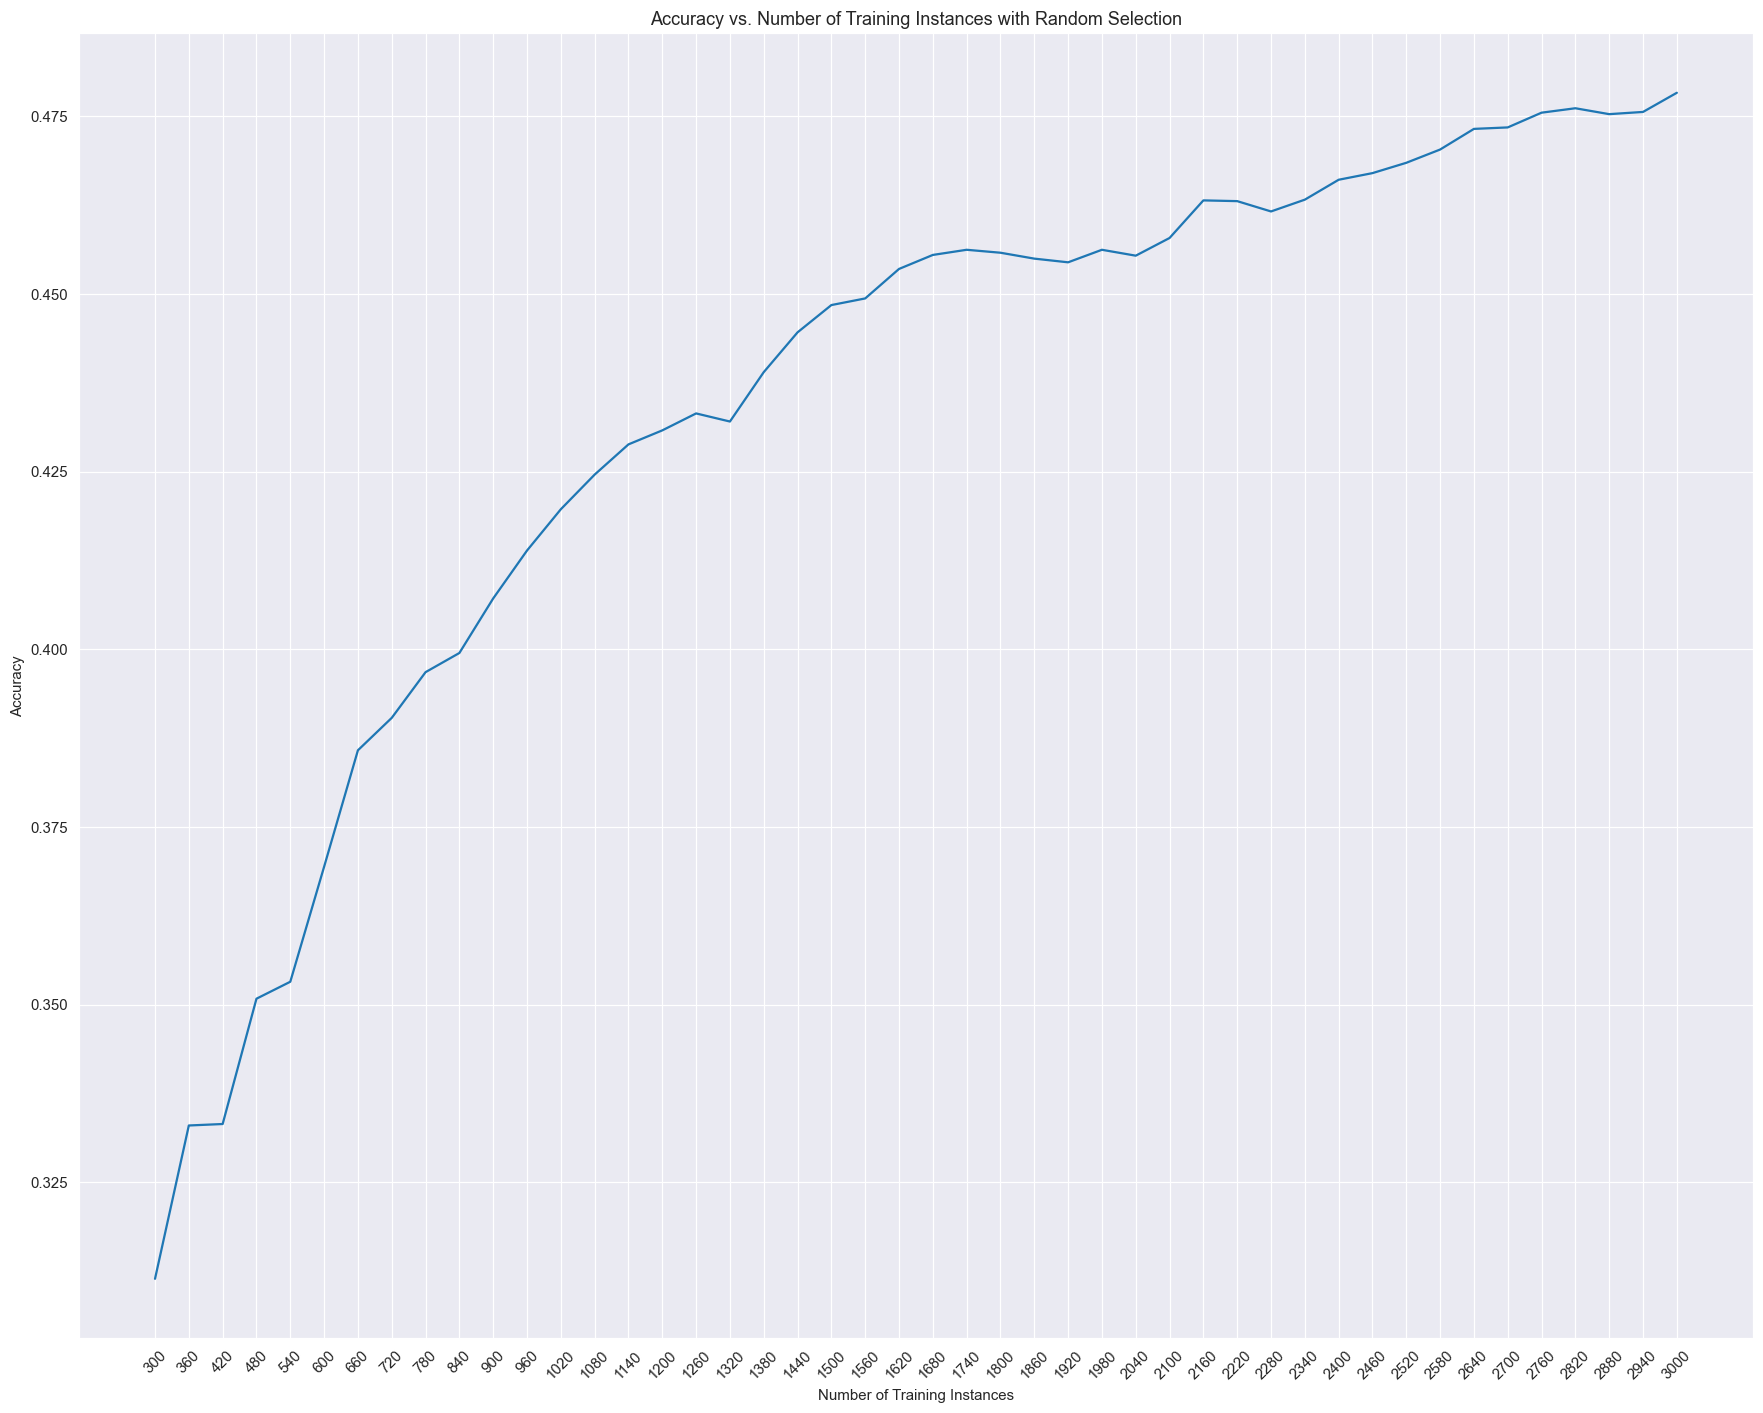

In [11]:
plot_accuracies('Random Selection', models_random, evaluate_logistic_regression_accuracy, X_test, y_test, len(seed_set), max_size, batch)

## 3. Uncertainty sampling

In [12]:
def logistic_regression_entropy_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values.
    """
    # fill in    
    probs = pd.DataFrame(sigmoid(X @ model))
    # Entropy = − Σ_y P_θ(y|x) * log(P_θ(y|x))
    probs = probs.apply(lambda a: -a*np.log2(a))
    entropies = probs.sum(axis=1)
    
    return entropies.tolist()
    

In [13]:
models_us = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_logistic_regression, 
                                 logistic_regression_entropy_select, 
                                 max_size, batch)

100%|██████████| 46/46 [07:56<00:00, 10.36s/it]


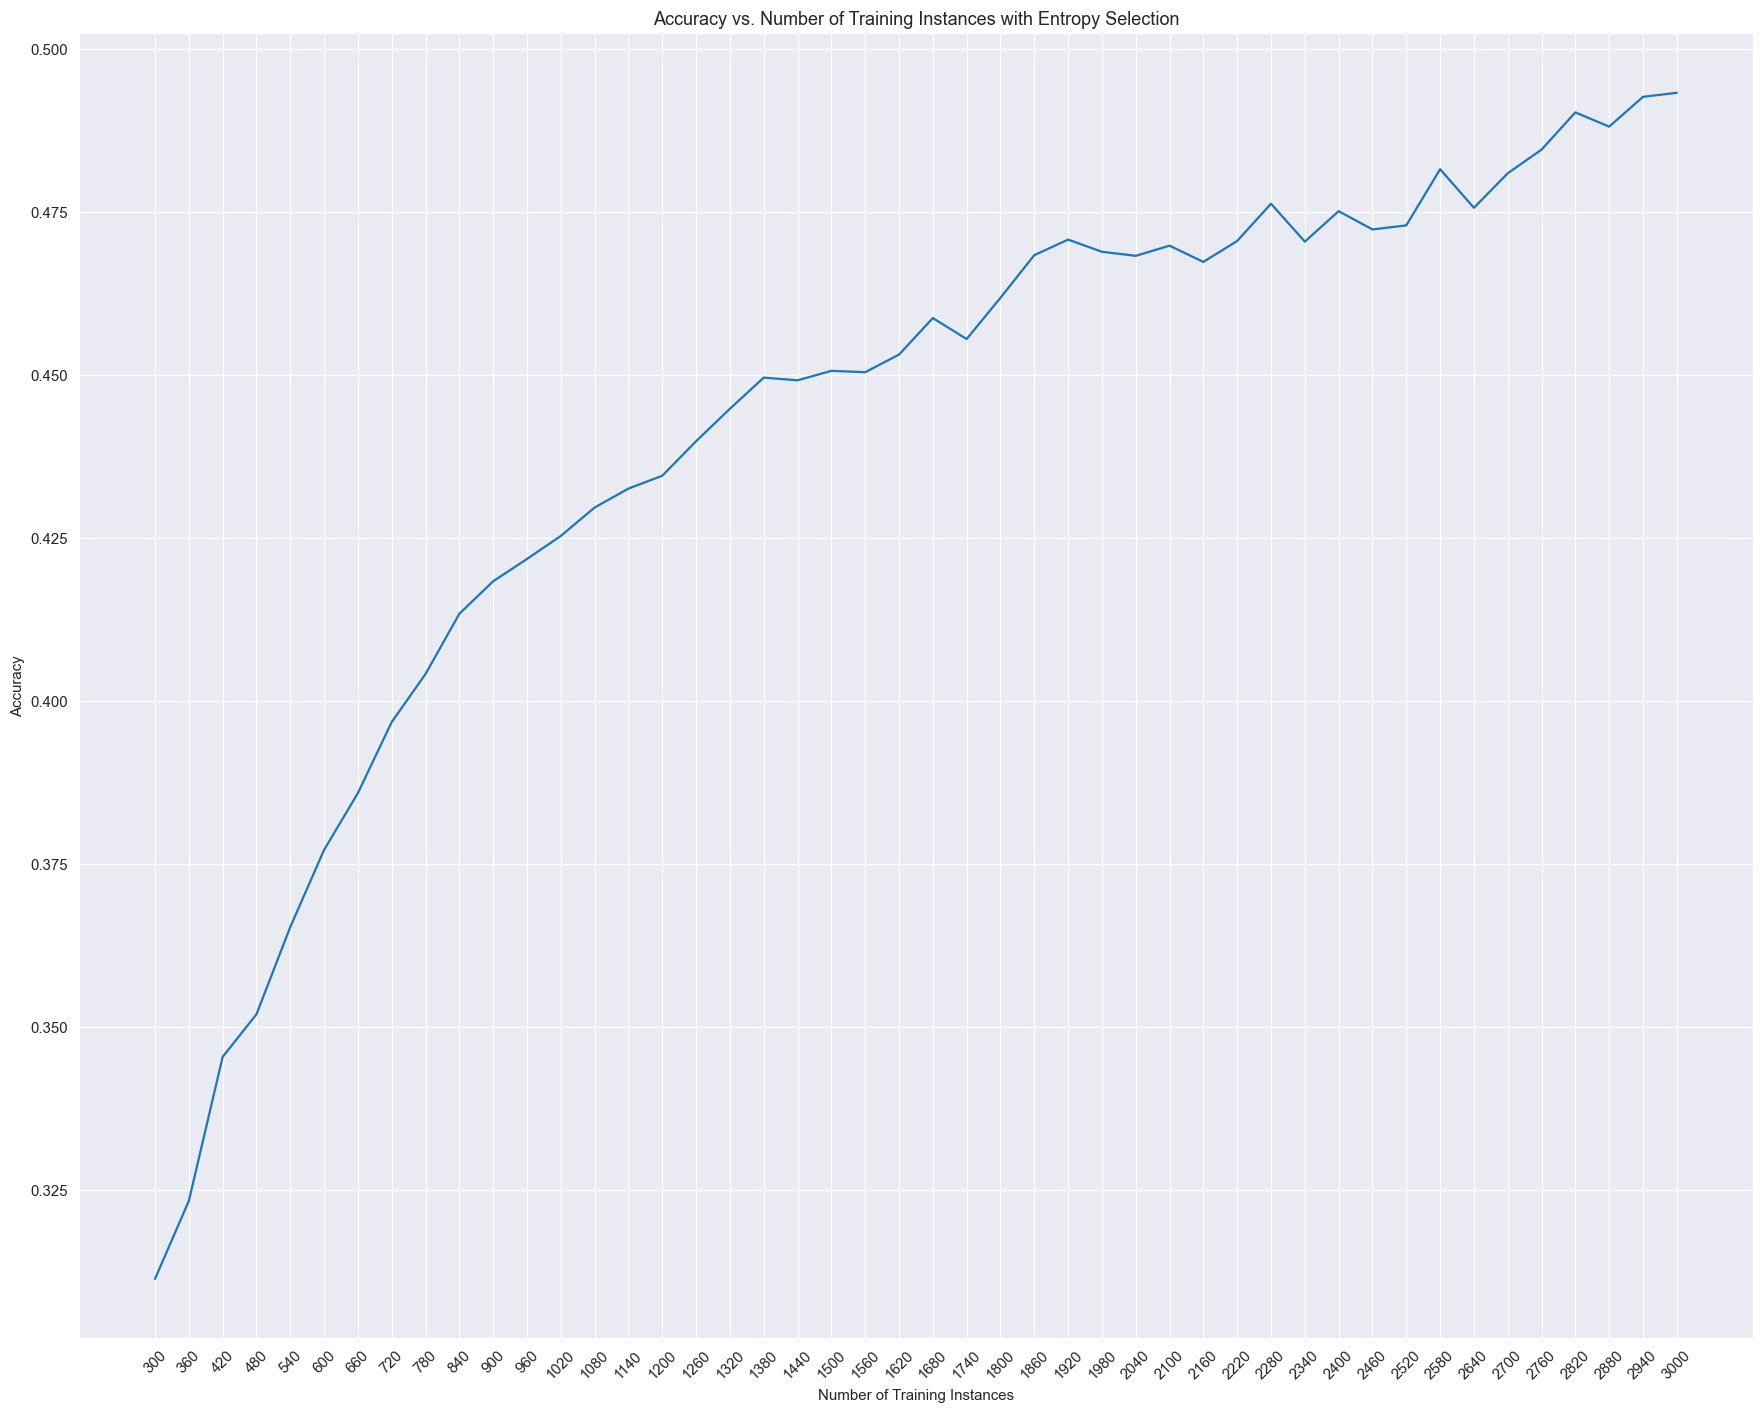

In [14]:
plot_accuracies('Entropy Selection', models_us, evaluate_logistic_regression_accuracy, X_test, y_test, len(seed_set), max_size, batch)

## 4. Query by committee

In [15]:
# don't forget to provide function descriptive comments, like those provided in templates above

def query_by_committee_vote_entropy(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and 
    a list of discriminative models for each committee in the ensemble
    [P(y|x)], returns a vector of n (hard) vote entropy values.
    """
    committee_size = len(model)
    thetas = []
    
    for h_theta in model:
        theta = sigmoid(X @ h_theta).values.argmax(axis=1)
        thetas.append(theta)
    
    vote_entropies = []
    
    for y_x in range(X.shape[0]): 
        
        # vote_C(y,x) = Σ_(θ ∈ C) 1_{h_θ(x) = y}
        votes = defaultdict(int)
        for C in range(committee_size):
            votes[thetas[C][y_x]] += 1
            
        # Vote Entropy = − Σ_y (vote_C(y,x)/|C|) * log(vote_C(y,x)/|C|)
        vote_entropy = 0
        for label, vote in votes.items():
            vote_entropy += -(vote/committee_size)*np.log2((vote/committee_size))
        vote_entropies.append(vote_entropy)
    
    return vote_entropies


def query_by_committee_soft_vote_entropy(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and 
    a list of discriminative models for each committee in the ensemble
    [P(y|x)], returns a vector of n soft-vote entropy values.
    """
    committee_size = len(model)
    
    # P_C(y|x) = (1/|C|) Σ_(θ ∈ C) P_θ(y|x)
    for committee in range(committee_size):
        probs = sigmoid(X @ model[committee])
        if committee == 0:
            consensus = probs
        else:
            consensus = consensus.add(probs)
            
    consensus = consensus.div(committee_size)
    
    # Soft Vote Entropy = − Σ_y P_C(y|x) * log(P_C(y|x))
    consensus = consensus.apply(lambda a: -a*np.log2(a))
    soft_vote_entropies = consensus.sum(axis=1)
    
    return soft_vote_entropies.tolist()


def query_by_committee_KL(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and 
    a list of discriminative models for each committee in the ensemble
    [P(y|x)], returns a vector of n Kullback-Leibler (KL) divergence values.
    """
    committee_size = len(model)
    thetas = []
    
    for h_theta in model:
        thetas.append(sigmoid(X @ h_theta))
    
    # Calculate P_C(y|x) as above
    for committee in range(committee_size):
        probs = thetas[committee]
        if committee == 0:
            consensus = probs
        else:
            consensus = consensus.add(probs)
    
    consensus = consensus.div(committee_size)
    
    # KL(P_θ(Y|x) ∥ P_C(Y|x)) = Σ_y P_θ(y|x) * log(P_θ(y|x)/P_C(y|x))
    KLs = []
    for theta in thetas:
        KL_divergence = theta.div(consensus)
        KL_divergence = KL_divergence.apply(lambda a: np.log2(a))
        KL_divergence = KL_divergence.mul(theta)
        KLs.append(KL_divergence.sum(axis=1))
    
    
    # KL = (1/|C|) Σ_(θ ∈ C) KL(P_θ(Y|x) ∥ P_C(Y|x))
    for committee in range(committee_size):
        comm = KLs[committee]
        if committee == 0:
            KL = comm
        else:
            KL = KL.add(comm)
     
    KL = KL.div(committee_size)
    
    return KL.tolist()

In [16]:
def train_committee(X, y, **args):
    """
    Train a vanilla logistic regression model 
    and an ensemble of models (both logistic regressions) on dataset (X, y) using bagging as the ensembling method
    and return the trained models.
    X: matrix of real values, size n x d
    y: vector of string labels, size n
    args: optional arguments e.g., for hyper-parameters
    """
#     ensemble_models = [SVC(kernel='poly', C=1, decision_function_shape='ovr'), DecisionTreeClassifier()]
    
    logistic_theta = train_logistic_regression(X, y)
    
    ensemble_size = 2
    X_df = pd.DataFrame(X)
#     y_df = pd.DataFrame(y)
    y_encode = encode_y(y)
    encodings = y_encode.iloc[:, 2:]
    
    ensemble_thetas = []
    
    for ensemble in range(ensemble_size):
#         print("Trying model", ensemble)
        seed = random.randint(0,10000)
        X_bagged = X_df.sample(frac=1, replace=True, random_state=seed)
        y_bagged = encodings.sample(frac=1, replace=True, random_state=seed)
#         theta = ensemble.fit(X_bagged, y_bagged)
#         ensemble_thetas.append(theta)
#         print("Finished with..\n", theta)
        ensemble_thetas.append(train_logistic_regression(X_bagged, y_bagged))
    
    return (logistic_theta, ensemble_thetas)


100%|██████████| 46/46 [19:05<00:00, 24.90s/it]


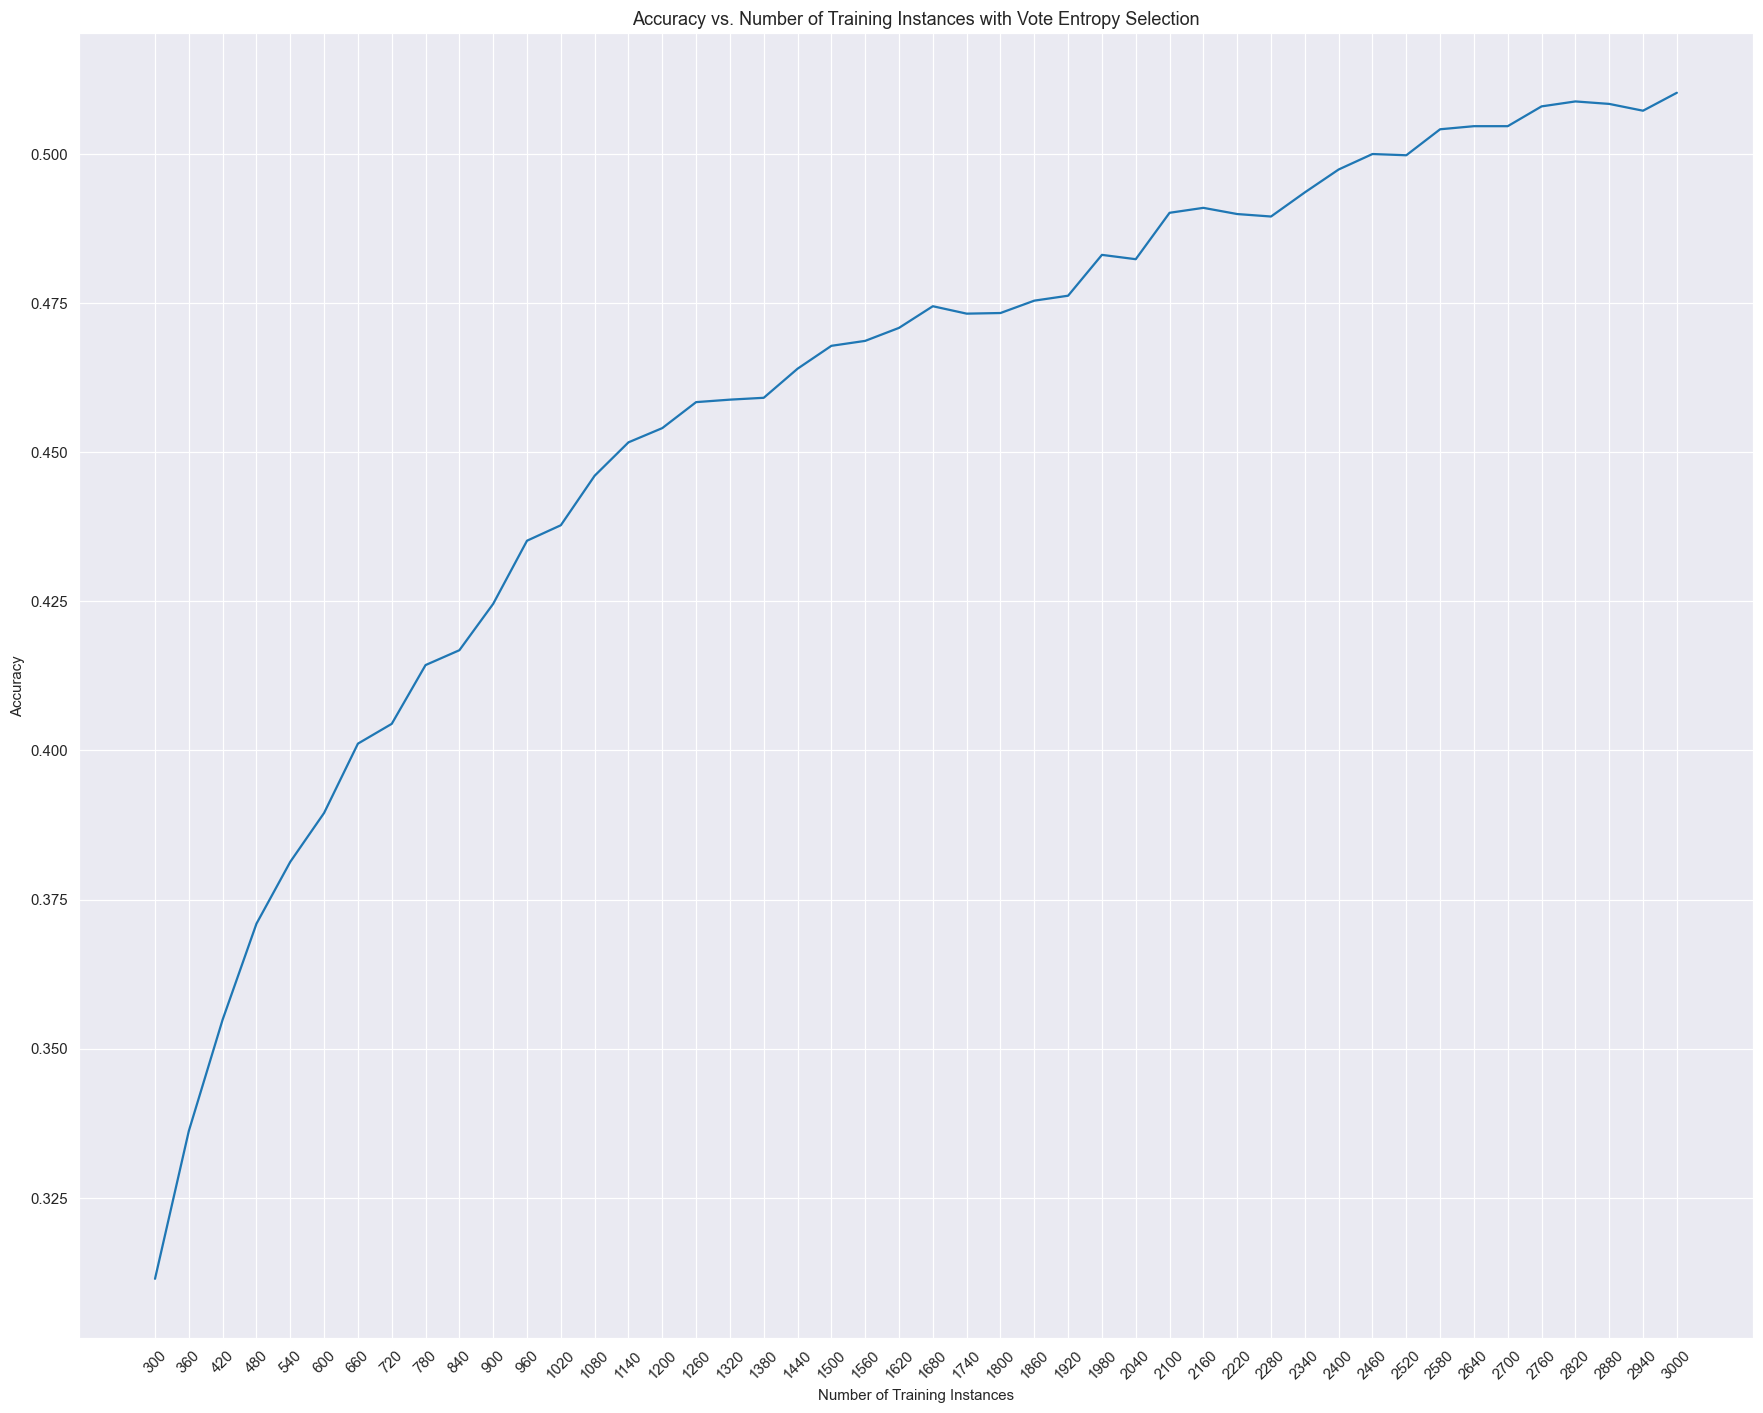

100%|██████████| 46/46 [19:47<00:00, 25.82s/it]


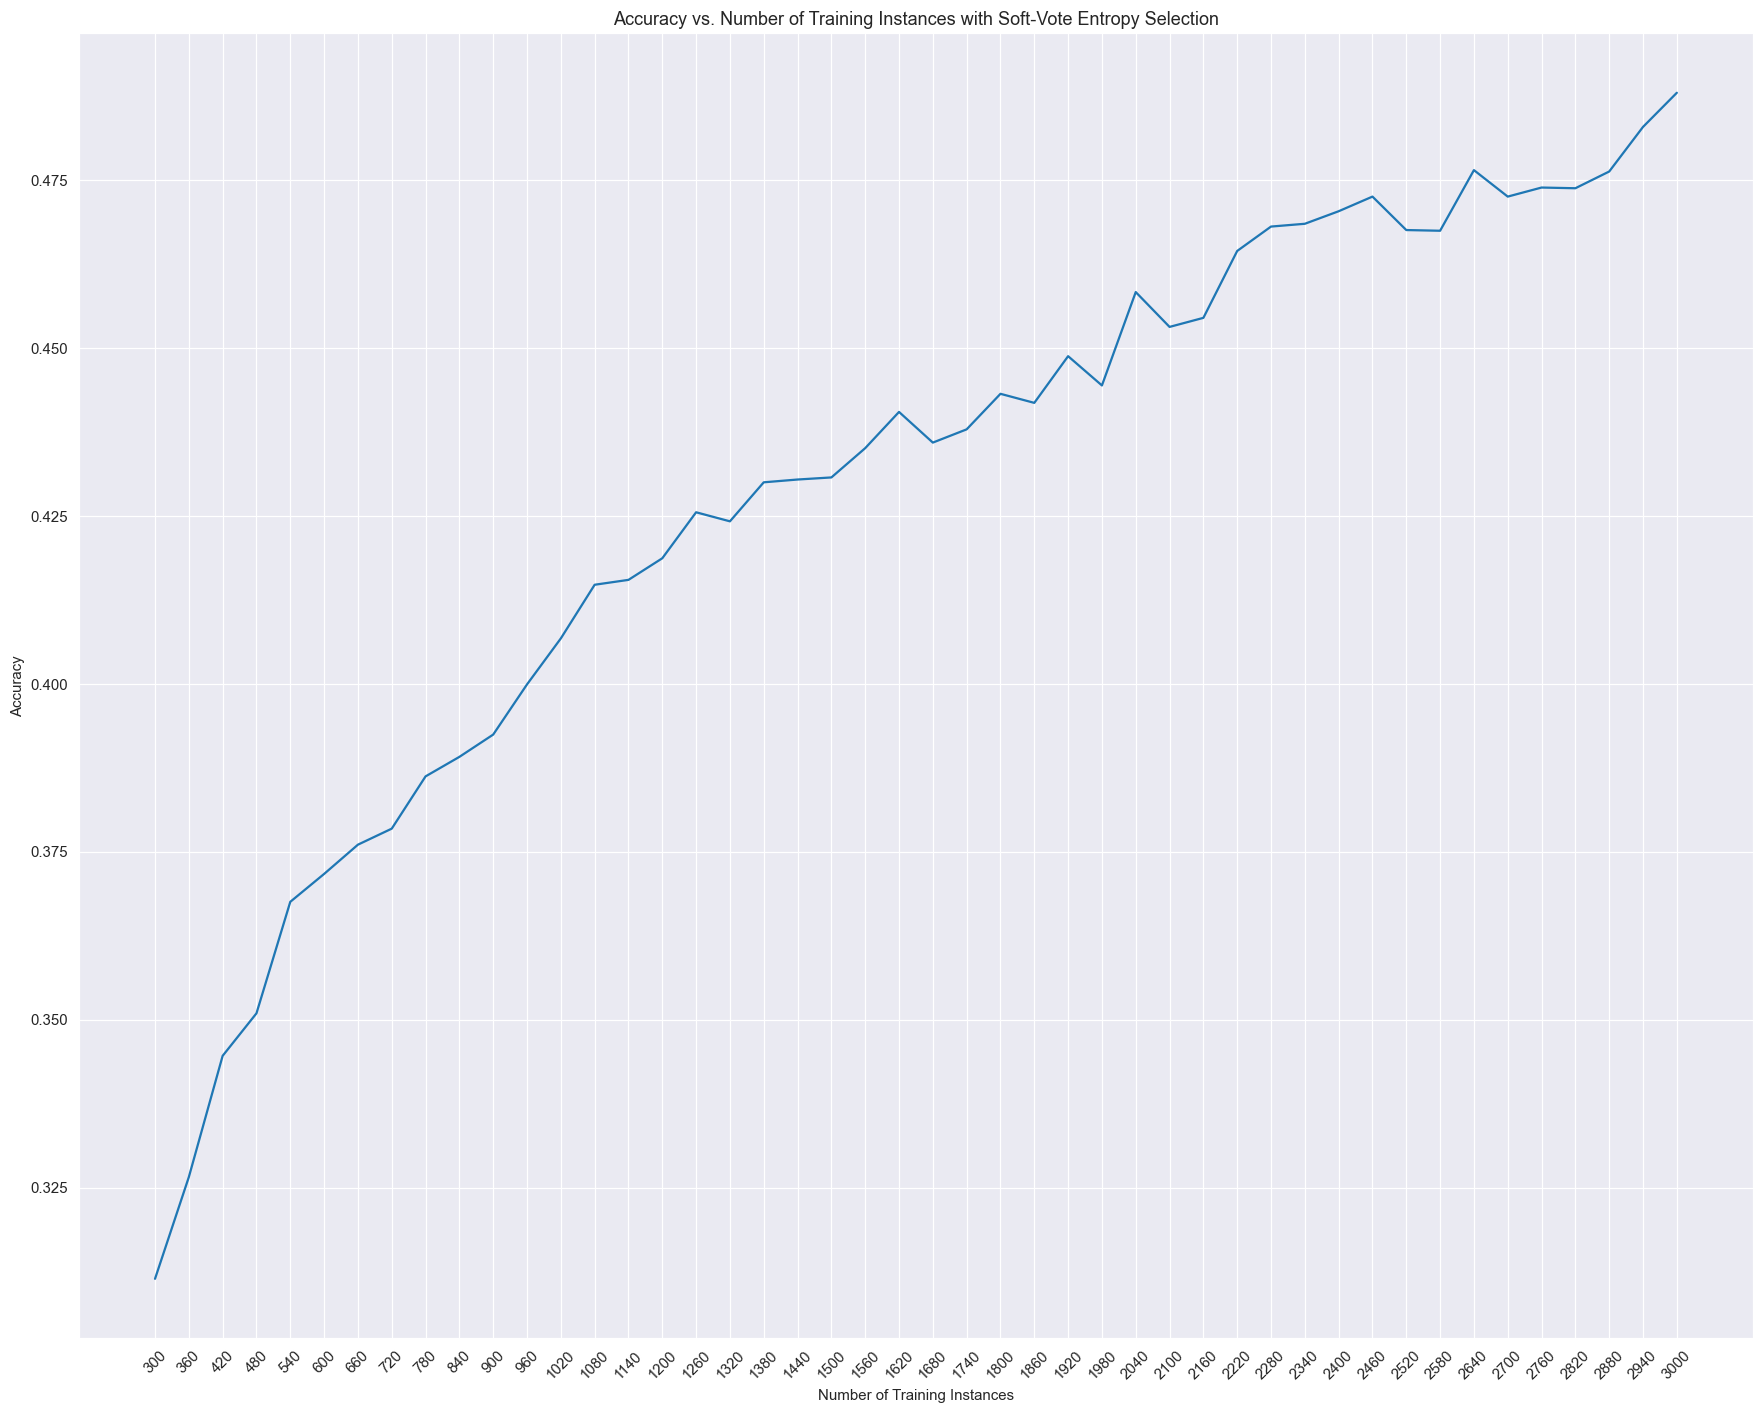

100%|██████████| 46/46 [23:58<00:00, 31.26s/it]


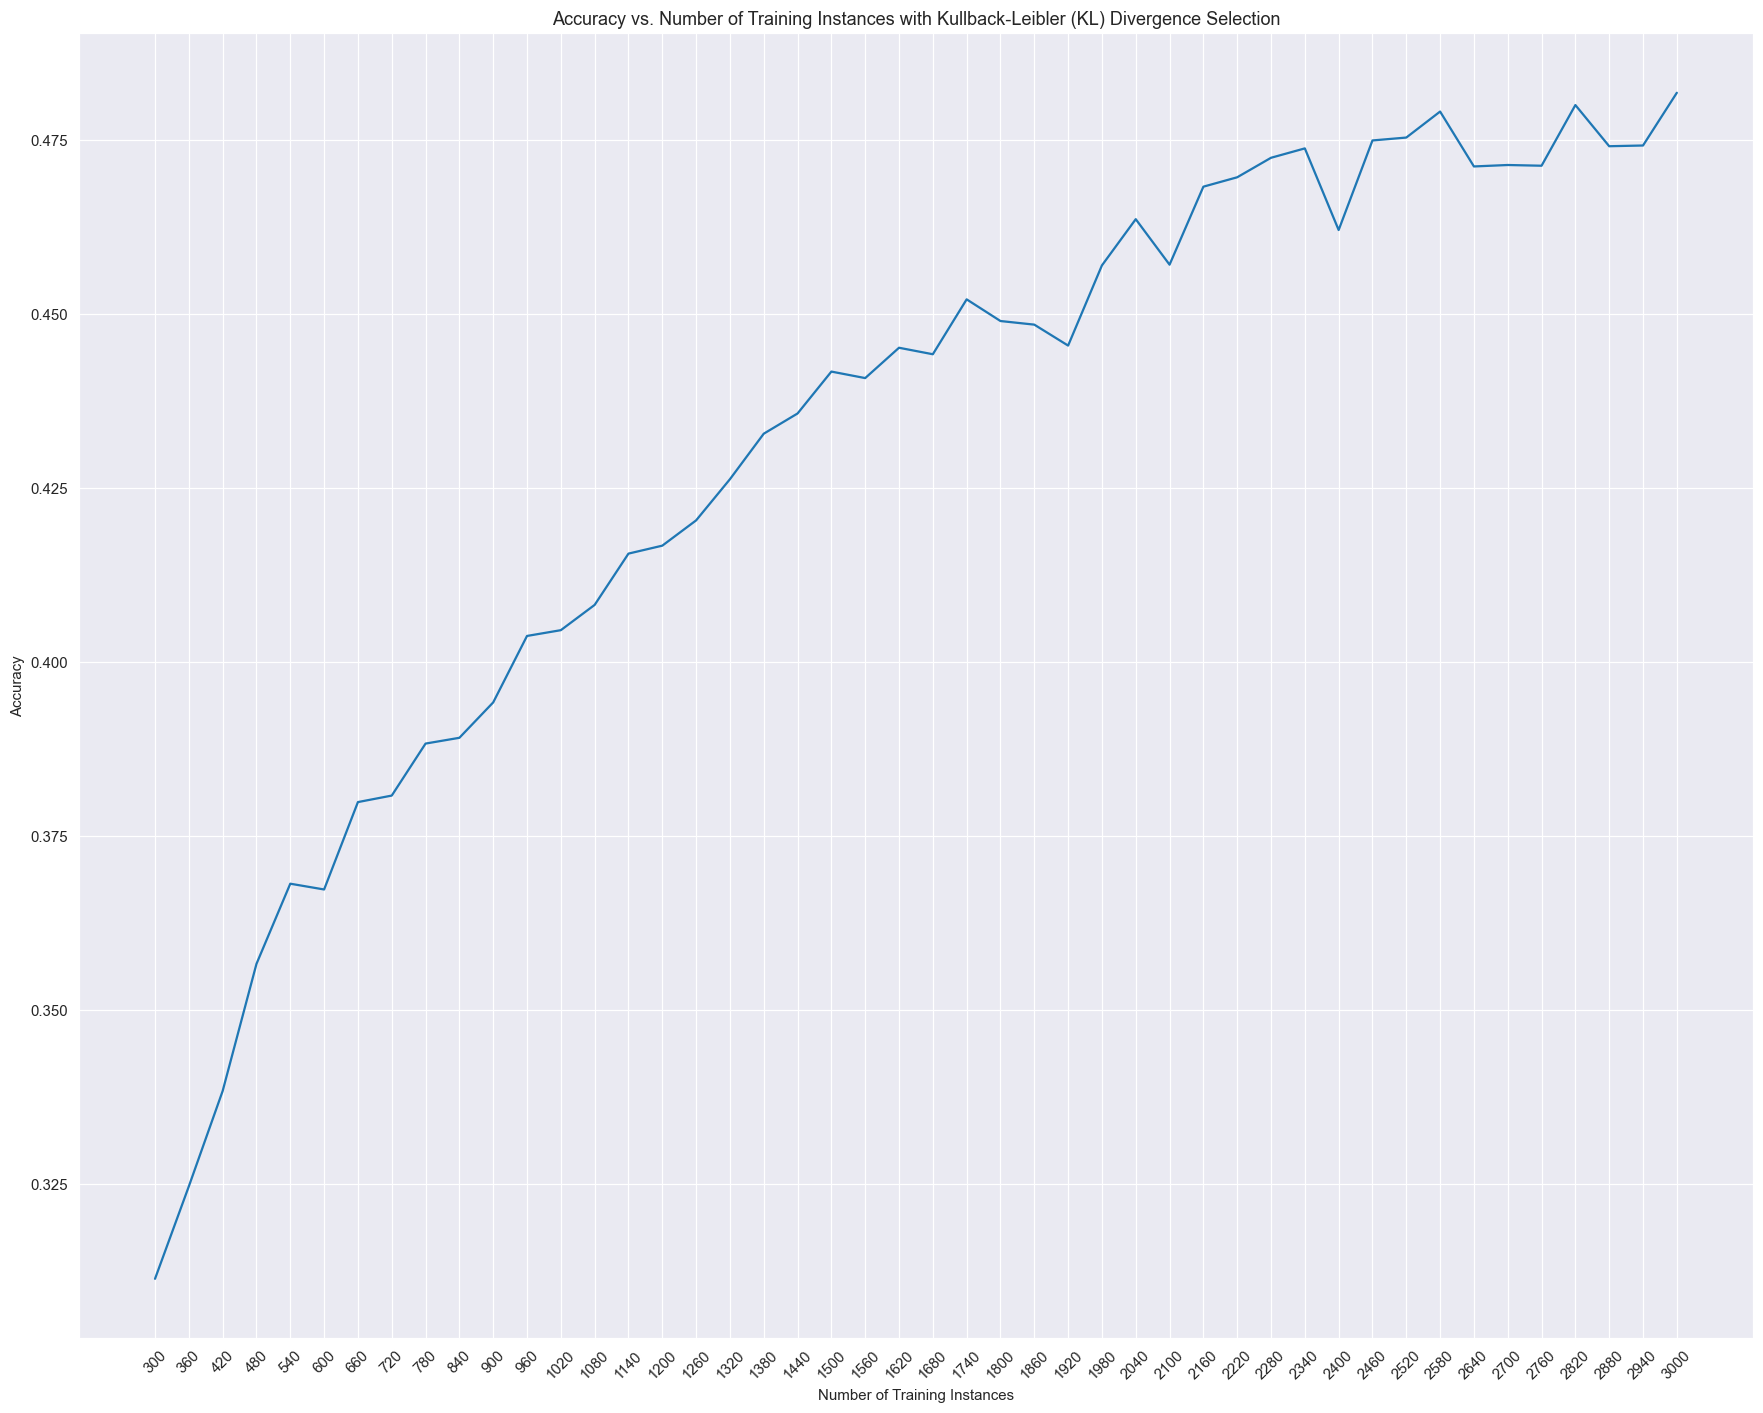

In [17]:
select_funcs = [('Vote Entropy Selection', query_by_committee_vote_entropy), 
                ('Soft-Vote Entropy Selection', query_by_committee_soft_vote_entropy), 
                ('Kullback-Leibler (KL) Divergence Selection', query_by_committee_KL)]

for select_func in select_funcs:
    models_comm = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_committee, 
                                 select_func[1], 
                                 max_size, batch)
    plot_accuracies(select_func[0],models_comm, evaluate_logistic_regression_accuracy, X_test, y_test, len(seed_set), max_size, batch)

## 5. Hierarchical sampling

In [18]:
def train_hierarchical_clustering(X, y, max_size, batch_size, beta, **args): 
    """
    Train a hierarchical clustering-based active learning model on dataset (X, y)
    with Agglomerative Clustering with average linkage and euclidean distance metric
    and return a list of assigned clusters based on different revealed instances.
    X: matrix of real values, size n x d
    y: vector of string labels, size n
    max_size: stopping condition for active learning, when labelled data reaches given size
    batch_size: number of instances to be labelled in each iteration
    beta: beta parameter used for determining admissibility of a node
    args: optional arguments e.g., for hyper-parameters
    """

    # Following the text, use agglomerative clustering with average linkage for clustering
    T = AgglomerativeClustering(affinity="euclidean", linkage="average")
    T = T.fit(X)
    n_leaves = len(X)

    ii = itertools.count(n_leaves)
    nodes_list = [{next(ii): {'left': x[0], 'right':x[1], 'n_v':defaultdict(int), 'p_v_l':{}, 'best_label': None}} for x in T.children_][::-1]
    
    nodes = {}
    labelled_instances = {}
    A_v_l = {}
    
    assignments = []
    
    for node in nodes_list:
        for parent, children in node.items():
            nodes[parent] = children
    
    # P ← {root} (current pruning of tree)
    # L(root) ← 1 (arbitrary starting label for root) 
    root = nodes_list[0]
    P = set()
    for root_id, value in root.items():
        P.add(root_id)
    

    # for time t = 1,2,... until the budget runs out do
    budget = max_size / batch_size
    
    for t in tqdm(range(int(budget))):
        
        selected_v = set()
        # for i = 1 to B do
        for i in range(batch_size):
            
            # v ← select(P)
            leaves = []
            while len(leaves) < 1:
                
                v_id = select_node(P)
                selected_v.add(v_id)
                v = {v_id: nodes[v_id]}
                # Pick a random point z from subtree Tv
                leaves = find_descendants(v, nodes, n_leaves, labelled_instances)
            
            
            z = random.choice(leaves)
            while z in labelled_instances:
                z = random.choice(leaves)
            # Query z’s label l    
            l = y[z]
            labelled_instances[z] = l
    
            # Update empirical counts and probabilities (nu(t),pu,l(t)) for all nodes u on path from z to v
            ancestors = find_ancestor(z, list(v.keys())[0], n_leaves, T.children_)
            for ancestor in ancestors[1:]:
                nodes[ancestor]['n_v'][l] += 1
                nodes[ancestor]['p_v_l'] = calculate_fraction(nodes[ancestor]['n_v'])
        # end for
            
        # In a bottom-up pass of T , update A and compute scores s(u, t) for all nodes u ∈ T (see text)
        A_v_l, best_labels, scores, split_ids = update_scores(nodes, nodes_list, A_v_l, beta, n_leaves, T)
        
        
        # for each (selected) v ∈ P do
        for selected in selected_v:
            
            # Let (P′,L′) be the pruning and labeling of Tv achieving scores s(v, t)
            # P ← (P \ {v}) ∪ P ′
            # L(v) ← L′(u) for all u ∈ P′
            P.remove(selected)
            P.update(split_ids)
            
        # end for 
        
        # for each cluster v ∈ P do
            # Assign each point in Tv the label L(v)
        assigned_points = {}
        for leaf in range(n_leaves):
            cluster_id = find_parent(leaf, nodes)
            while cluster_id not in best_labels:
                cluster_id = find_parent(cluster_id, nodes)
            
            label = best_labels[cluster_id]
            assigned_points[leaf] = label
            
        # end for
        assignments.append(assigned_points)
    # end for
    
    return assignments


def node_upper_lower_bounds(n_v, p_v):
    """
    Calculate the confidence interval of p_v_l for each node
    and return a dictionary of label-confidence interval key-value pairs
    n_v: frequency of each label appearing in subtree T_v
    p_v: empirical probabilities of each label appearing in subtree T_v
    """
    node_bounds = {}
    
    for l, p_v_l in p_v.items():
        delta = (1/n_v) + np.sqrt(p_v_l * (1 - p_v_l) / n_v)
        lower_bound = np.maximum(p_v_l - delta, 0)
        upper_bound = np.minimum(p_v_l + delta, 1)
        
        node_bounds[l] = (lower_bound, upper_bound)
        
    return node_bounds

def node_admissibility(n_v, p_v, beta):
    """
    Calculate the admissibility of each node to determine our confidence in the majority label of the node
    and return a dictionary of node-labels for which the labels make the node admissible
    n_v: frequency of each label appearing in subtree T_v
    p_v: empirical probabilities of each label appearing in subtree T_v
    beta: beta parameter used for determining admissibility of a node
    """
    if n_v == 0:
        return None
    
    all_lower = []
    all_upper = []
    all_l = []
    
    node_bounds = node_upper_lower_bounds(n_v, p_v)
    
    for l, bounds in node_bounds.items():
        all_lower.append(bounds[0])
        all_upper.append(bounds[1])
        all_l.append(l)
    
    A_v_l = {}
    for i, l in enumerate(all_l):     
        all_other_upper = [1 - all_upper[c] for c in range(len(all_l)) if c != i ]
        if len(all_other_upper) > 0: 
            A_v_l[l] = 1 - all_lower[i] < beta * min(all_other_upper)
        else:
            A_v_l[l] = False
    
    return A_v_l

def best_label_score(p_v_l, admissible):
    """
    Calculate the majority label and the adjusted error of the label of the node
    and return the best label and the score associated with it
    p_v_l: empirical probabilities of all labels appearing in subtree T_v
    admissible: dictionary of node-labels for which the labels make the node admissible
    """
    adjusted_errors = {}
    best_label = None
    best_error = 10 # arbitrary number more than 1
    for l, p_v in p_v_l.items():
        error = 1 - p_v
        if admissible[l] == False:
            error = 1
            
        if error < best_error:
            best_label = l
            best_error = error
            
    return best_label, best_error

def update_scores(all_nodes, nodes_list, A_v_l, beta, n_leaves, model):
    """
    Compute scores s(u,t) for all the nodes in the tree T and perform bottom up pass of T while updating the nodes
    and return an updated A_v_l, a dictionary of best labels for each node, scores s(v,t), and the nodes 
    that would be best considered for pruning based on the score s(v,t)
    all_nodes: dictionary of nodes in the tree
    nodes_list: list of each node in the tree
    A_v_l: dictionary of node-labels for which the labels make the node admissible
    beta: beta parameter used for determining admissibility of a node
    n_leaves: number of leaves (data instances)
    model: model representing the agglomerative clustering of the tree
    """
    node_set = set()
    for nodes in nodes_list[::-1]:
        for node_id, value in nodes.items():
            if (value['left'] < n_leaves or value['right'] < n_leaves):
                node_set.add(node_id)
    
    admissible_v_l = A_v_l
    best_labels = {}
    scores = {}
    split_ids = set()
    
    while len(node_set) > 0:
        parents = set()
    
        for node_id in node_set:

            values = all_nodes[node_id]

            admissible = node_admissibility(sum(values['n_v'].values()), values['p_v_l'], beta)
            score = 0
            if admissible != None:
                has_admissible = False
                for l, admissibility in admissible.items(): 
                    if admissibility == True:
                        has_admissible = True
                        admissible_v_l[node_id] = l

                label, score = best_label_score(values['p_v_l'], admissible)
                best_labels[node_id] = label


                if has_admissible:

                    ancestors = find_ancestor(node_id, list(all_nodes.keys())[0], n_leaves, model.children_)
                    all_admissible_ancestors = True
                    for ancestor in ancestors:
                        
                        if ancestor not in admissible_v_l:
                            all_admissible_ancestors = False
                        
                    
                    if all_admissible_ancestors:
                        left_id = values['left']
                        if left_id < n_leaves:
                            left_score = 0
                            left_leaves = 0
                        else:
                            left_node = all_nodes[left_id]
                            left_admissibility = node_admissibility(sum(left_node['n_v'].values()), left_node['p_v_l'], beta)
                            if left_admissibility == None:
                                left_score = 0
                            else:
                                left_label, left_score = best_label_score(left_node['p_v_l'], left_admissibility)
                            left_leaves = len(find_descendants({left_id: left_node}, all_nodes, n_leaves, []))
                        
                        
                        right_id = values['right']
                        if right_id < n_leaves:
                            right_score = 0
                            right_leaves = 0
                        else:
                            right_node = all_nodes[right_id]
                            right_admissibility = node_admissibility(sum(right_node['n_v'].values()), right_node['p_v_l'], beta)
                            if right_admissibility == None:
                                right_score = 0
                            else:
                                right_label, right_score = best_label_score(right_node['p_v_l'], right_admissibility)
                            right_leaves = len(find_descendants({right_id: right_node}, all_nodes, n_leaves, []))
                        
                        v_leaves = len(find_descendants({node_id: values}, all_nodes, n_leaves, []))
                        
                        split_score = (left_leaves * left_score + right_leaves * right_score) / v_leaves

                        if split_score < score:
                            score = split_score
                            split_ids.add(node_id)
                            
            scores[node_id] = score
            for root_id, root_values in nodes_list[0].items():
                if node_id < root_id:
                    parent = find_parent(node_id, all_nodes)
                    parents.add(parent)
                    
            node_set = parents
        
    return admissible_v_l, best_labels, scores, split_ids

def calculate_fraction(label_counts):
    """
    Calculate the proportion of the labels with respect to label frequency counts and return the dictionary of 
    label-proportion key-value pairs
    label_counts: frequency of each label appearing in subtree T_v
    """
    total = sum(label_counts.values())
    p_v_l = {}
    for label, count in label_counts.items():
        p_v_l[label] = count/total
    return p_v_l
    
def select_node(P):
    """
    Select the next node to query from and return the node
    P: current pruning of the tree
    """
    
    # TODO: implement active learning based on |Tv|(1−p ̆v,L(v))    
    return random.sample(P, 1)[0]

def find_parent(leaf, all_nodes):
    """
    Find and return the parent id of a leaf node
    leaf: id of the node we want to find the parent for
    all_nodes: all the nodes appearing in the tree T
    """
    for parent, values in all_nodes.items():
        if leaf == values['left'] or leaf == values['right']:
            return parent

def find_descendants(nodes, all_nodes, max_child_id, labelled_instances):
    """
    Find and return all the leaf nodes of a particular node
    nodes: node for which we want to find the descendants of
    all_nodes: all the nodes appearing in the tree T
    max_child_id: the maximum number that a leaf node id will be
    labelled_instances: list of descendants that we would like to ignore
    """
    leaves = []
    
    for parent, children in nodes.items():
        for child in ['left', 'right']:
            child_id = children[child]
            if child_id < max_child_id:
                if child_id not in labelled_instances:
                    leaves.append(child_id)
            else:
                grandchildren = all_nodes[child_id]
                leaves += find_descendants({child_id: grandchildren}, all_nodes, max_child_id, labelled_instances)
    return leaves

def find_ancestor(leaf, v, N, model_children):
    """
    Find and return the path of a leaf node all the way to node v
    leaf: node for which we want to find the path of ancestors of
    v: root node
    N: number of leaf instances in the tree
    model_children: array of children pair of the tree
    """
    for ind,pair in enumerate(model_children):
        if leaf in pair:
            if leaf < v:
                return [leaf]+find_ancestor(N+ind, v, N, model_children)
            else:
                return []
    return [ind+N]

100%|██████████| 5/5 [00:19<00:00,  3.88s/it]


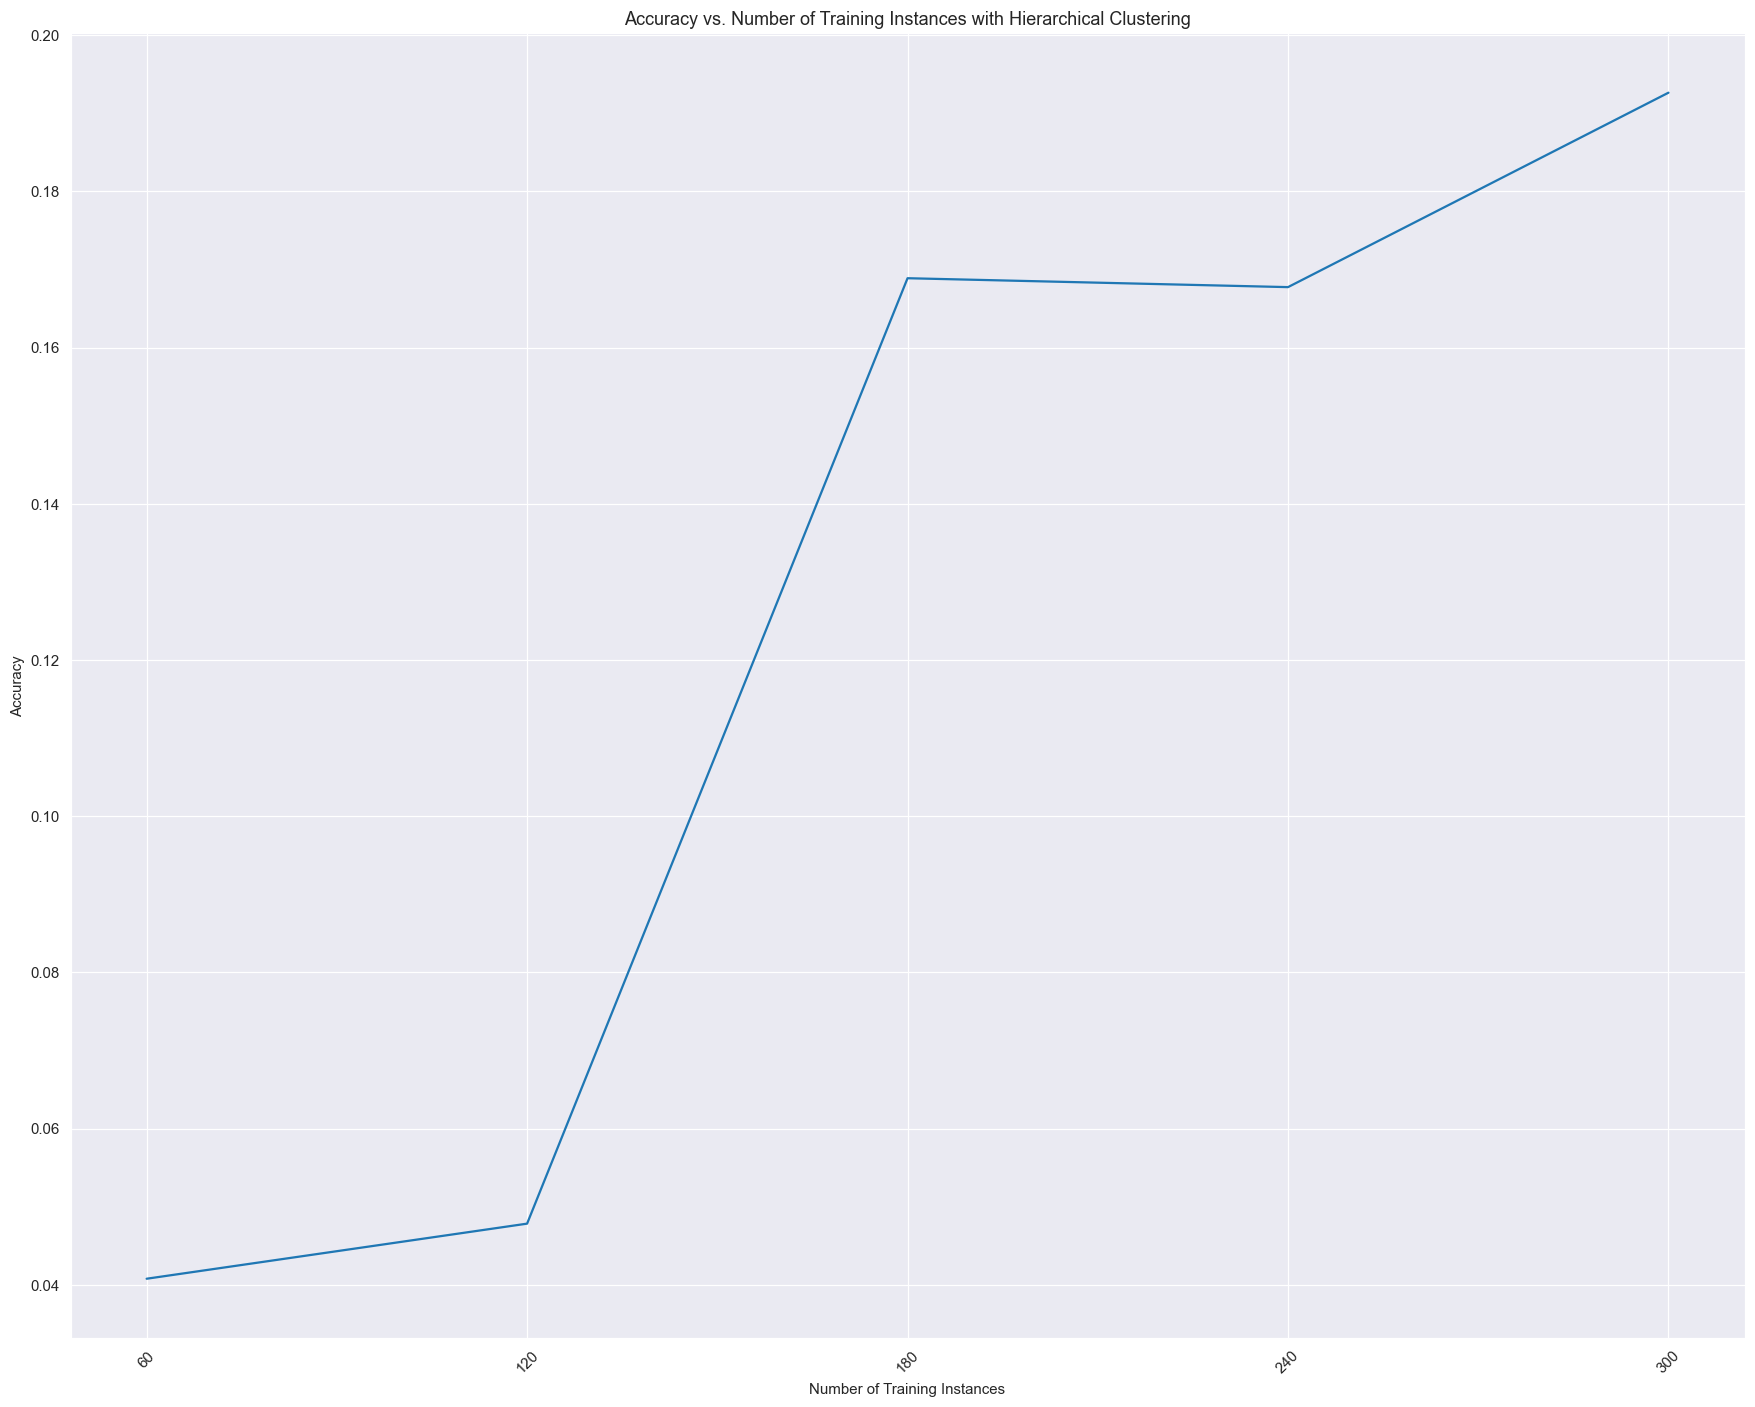

In [23]:
# Unfortunately, my code takes forever to run for X_pool and y_pool due to the sheer size
# of the tree (due to a poorly designed update_score function), but to show that it actually works,
# I'll run it with the seed ones and show the increase in accuracies

beta = 2
# assignments = train_hierarchical_clustering(X_pool, y_pool, max_size, batch, beta)
assignments = train_hierarchical_clustering(X_seed, y_seed, 300, batch, beta)
accuracies = []
for assignment in assignments:
    
    assigned_y = list(assignment.values())
    # lr = train_logistic_regression(X_pool, assigned_y)
    lr = train_logistic_regression(X_seed, assigned_y)
    accuracies.append(evaluate_logistic_regression_accuracy(X_test, y_test, lr))
        
plt.figure(figsize=(20,16))
# x_axis = range(0, max_size, batch)
x_axis = range(batch, 300+1, batch)
plt.plot(x_axis, accuracies)
plt.title('Accuracy vs. Number of Training Instances with Hierarchical Clustering')
plt.ylabel('Accuracy')
plt.xlabel('Number of Training Instances')
plt.xticks(x_axis, rotation=45)
plt.show()


In [24]:
print("""
You:                                Me:
(\_/)                              (\__/)
( •-•) – Here you go   Ty senpai – (•o• )
/>  >H1                            <   <\\

"""
)


You:                                Me:
(\_/)                              (\__/)
( •-•) – Here you go   Ty senpai – (•o• )
/>  >H1                            <   <\




## your code